In [1]:
import librosa
from matplotlib import pyplot as plt
import librosa.display
import IPython.display as ipd
import os
import audioread
from matplotlib.pyplot import specgram
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn import svm

In [2]:
def load_data(sr=16000):
    temp_list = os.listdir('cats_dogs')
    temp_list.sort()
    cats = []
    channel_cats = []
    dogs = []
    channel_dogs = []
    for i in range(164):
        cats.append(librosa.load('cats_dogs/' + temp_list[i],sr=sr))
        with audioread.audio_open('cats_dogs/' + temp_list[i]) as input_file:
            channel_cats.append(input_file.channels)
    for j in range(164,277):
        dogs.append(librosa.load('cats_dogs/' + temp_list[j],sr=sr))
        with audioread.audio_open('cats_dogs/' + temp_list[j]) as input_file:
            channel_dogs.append(input_file.channels)
    channel_cats = list(set(channel_cats))
    channel_dogs = list(set(channel_dogs))
    print('Cats audio files loaded: ' + str(len(cats)) + ' samples')
    print('Dogs audio files loaded: ' + str(len(dogs)) + ' samples')
    if len(channel_cats)==1 and channel_cats[0]== 1:
        print("Only one channel for cats files")
    else:
        print("Attention ! Some audio cats files have several channels")
    if len(channel_dogs)==1 and channel_dogs[0]== 1:
        print("Only one channel for dogs files")
    else:
        print("Attention ! Some audio dogs files have several channels")
    
    return cats,dogs

In [3]:
def compute_mel_frequencies(cats,dogs,sr=16000):
    cats_mel_frequencies = []
    dogs_mel_frequencies = []
    
    for i in range(len(cats)):
        cats_mel_frequencies.append(librosa.feature.melspectrogram(y=np.array(cats[i][0]),sr=sr))
    for i in range(len(dogs)):
        dogs_mel_frequencies.append(librosa.feature.melspectrogram(y=np.array(dogs[i][0]),sr=sr))
        
    return cats_mel_frequencies,dogs_mel_frequencies

In [4]:
def compute_mfccs(cats_mel_frequencies,dogs_mel_frequencies,sr=16000):
    cats_mfccs = []
    dogs_mfccs = []
    
    for i in range(len(cats_mel_frequencies)):
        cats_mfccs.append(librosa.feature.mfcc(S=librosa.power_to_db(cats_mel_frequencies[i]),sr=sr))
    for i in range(len(dogs_mel_frequencies)):
        dogs_mfccs.append(librosa.feature.mfcc(S=librosa.power_to_db(dogs_mel_frequencies[i]),sr=sr))
        
    return cats_mfccs,dogs_mfccs

In [5]:
def compute_deltas(cats_mfccs,dogs_mfccs):
    cats_deltas = []
    dogs_deltas = []
    
    for i in range(164):
        cats_deltas.append(librosa.feature.delta(cats_mfccs[i]))
    for i in range(113):
        dogs_deltas.append(librosa.feature.delta(dogs_mfccs[i]))
        
    return cats_deltas,dogs_deltas

In [6]:
def build_df_mfccs(cats_mfccs,dogs_mfccs):
    df_cats = pd.DataFrame(np.transpose(cats_mfccs[0]),index=np.ones(len(np.transpose(cats_mfccs[0])))*(0+1))
    for i in range(1,len(cats_mfccs)):
        df_temp = pd.DataFrame(np.transpose(cats_mfccs[i]),index=np.ones(len(np.transpose(cats_mfccs[i])))*(i+1))
        frames = [df_cats, df_temp]
        df_cats = pd.concat(frames)
    df_cats['Label']=0
    
    df_dogs = pd.DataFrame(np.transpose(dogs_mfccs[0]),index=np.ones(len(np.transpose(dogs_mfccs[0])))*(0+len(cats_mfccs)+1))
    for i in range(1,len(dogs_mfccs)):
        df_temp = pd.DataFrame(np.transpose(dogs_mfccs[i]),index=np.ones(len(np.transpose(dogs_mfccs[i])))*(i+len(cats_mfccs)+1))
        frames = [df_dogs, df_temp]
        df_dogs = pd.concat(frames)
    df_dogs['Label']=1
    
    frames = [df_cats, df_dogs]
    result = pd.concat(frames)
    
    result = result.sample(frac=1)
    
    return result

In [7]:
def remove_frames(cats,dogs,cats_frames,dogs_frames,sr=16000):
    
    detect_cats = []
    detect_dogs = []
    
    for cat in cats:
        detect_cats.append(librosa.onset.onset_detect(y=cat[0]))
    for dog in dogs:
        detect_dogs.append(librosa.onset.onset_detect(y=dog[0]))
    
    
    new_cats_frames = []
    new_dogs_frames = []
    
    for k in range(len(cats_frames)):
        new_cats_frames.append([[cats_frames[k][i][j] for j in detect_cats[k]] for i in range(len(cats_frames[0]))])   
    for k in range(len(dogs)):
        new_dogs_frames.append([[dogs_frames[k][i][j] for j in detect_dogs[k]] for i in range(len(dogs_frames[0]))])
        
    return new_cats_frames,new_dogs_frames
    

In [8]:
def split_data(cats_frames,dogs_frames,n_cats,n_dogs,test_size=0.3):
    y_cats = np.zeros(n_cats)
    y_dogs = np.ones(n_dogs)

    X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(cats_frames, y_cats, test_size= test_size, random_state=42)
    X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs = train_test_split(dogs_frames, y_dogs, test_size= test_size, random_state=42)

    df_train = build_df_mfccs(X_train_cats,X_train_dogs)
    df_test = build_df_mfccs(X_test_cats,X_test_dogs)
    
    return df_train,df_test

In [9]:
def log_reg(df_train,df_test):
    logreg = LogisticRegression()
    X_train=df_train.iloc[:,0:df_train.shape[1]-1]
    X_test = df_test.iloc[:,0:df_train.shape[1]-1]
    y_train=df_train['Label']
    logreg.fit(X_train, y_train)
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)

    pred_train_series = pd.Series(y_pred_train,index = df_train.index)
    pred_group_train_series = pred_train_series.groupby(pred_train_series.index).mean()
    pred_train_boolean = pred_group_train_series >=0.5
    y_pred_train_last= pred_train_boolean*1

    pred_test_series = pd.Series(y_pred_test,index = df_test.index)
    pred_group_test_series = pred_test_series.groupby(pred_test_series.index).mean()
    pred_test_boolean = pred_group_test_series >=0.5
    y_pred_test_last= pred_test_boolean*1

    y_train = df_train['Label']
    y_train_last = y_train.groupby(y_train.index).mean()

    y_test = df_test['Label']
    y_test_last = y_test.groupby(y_test.index).mean()
    
    return y_train_last,y_pred_train_last,y_test_last,y_pred_test_last

In [10]:
def classification_svm(df_train,df_test,C,gamma):
    clf = svm.SVC(C=C, gamma = gamma)
    X_train=df_train.iloc[:,0:df_train.shape[1]-1]
    X_test = df_test.iloc[:,0:df_train.shape[1]-1]
    y_train=df_train['Label']
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    pred_train_series = pd.Series(y_pred_train,index = df_train.index)
    pred_group_train_series = pred_train_series.groupby(pred_train_series.index).mean()
    pred_train_boolean = pred_group_train_series >=0.5
    y_pred_train_last= pred_train_boolean*1

    pred_test_series = pd.Series(y_pred_test,index = df_test.index)
    pred_group_test_series = pred_test_series.groupby(pred_test_series.index).mean()
    pred_test_boolean = pred_group_test_series >=0.5
    y_pred_test_last= pred_test_boolean*1

    y_train = df_train['Label']
    y_train_last = y_train.groupby(y_train.index).mean()

    y_test = df_test['Label']
    y_test_last = y_test.groupby(y_test.index).mean()
    
    return y_train_last,y_pred_train_last,y_test_last,y_pred_test_last

In [11]:
def calculate_accuracies(y_train,y_pred_train,y_test,y_pred_test):
    train_accuracy = np.sum(np.array([y_train==y_pred_train]))/len(y_train)
    test_accuracy = np.sum(np.array([y_test==y_pred_test]))/len(y_test)
    return train_accuracy, test_accuracy

In [12]:
def class_report(y_train,y_pred_train,y_test,y_pred_test,train_accuracy,test_accuracy):
    
    print('\n\nTraining Set:\n')
    print('Training Confusion Matrix:')
    print(confusion_matrix(y_train, y_pred_train))
    
    print('Training Classification report:')
    print(classification_report(y_train, y_pred_train))
    
    print('Train Accuracy: ' + str(train_accuracy))
    
    print('\n\nTest Set:\n')
    print('Test Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred_test))
    
    print('Test Classification report:')
    print(classification_report(y_test, y_pred_test))

    print('Test Accuracy: ' + str(test_accuracy))
    


In [50]:
def cross_validate(df_train,folds):
    
#     C_range = np.arange(1,100000,10000)
#     gamma_range = np.arange(1,100000,10000)
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    results=np.empty((folds,len(C_range),len(gamma_range)))
    i=0
    j=0
    k=0
    X = np.unique(df_train.index.values)
    np.random.shuffle(X)
    kf = KFold(n_splits=3)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = df_train.loc[X[train_index]], df_train.loc[X[test_index]]

        for C in C_range:
            for gamma in gamma_range:
                y_train_last_svm,y_pred_train_last_svm,y_test_last_svm,y_pred_test_last_svm = classification_svm(X_train,X_test,C,gamma)
                train_acc,test_acc = calculate_accuracies(y_train=y_train_last_svm, y_pred_train = y_pred_train_last_svm, y_test = y_test_last_svm,y_pred_test = y_pred_test_last_svm)
                results[k,i,j]=test_acc
                j+=1
            i+=1
            j=0
        k+=1
        i=0
    average_acc = np.sum(results,axis=0)/folds
    indexes_max = np.unravel_index(np.argmax(average_acc, axis=None), average_acc.shape)
    best_C = C_range[indexes_max[0]]    
    best_gamma = gamma_range[indexes_max[1]] 
        
    return best_C, best_gamma

In [14]:
#Loading of the Data / Counting of Channels 
cats,dogs = load_data()
n_dogs = len(dogs)
n_cats = len(cats)

Cats audio files loaded: 164 samples
Dogs audio files loaded: 113 samples
Only one channel for cats files
Only one channel for dogs files


In [15]:
#Example of audio file cats_1
x=cats[0][0]
ipd.Audio(x,rate=16000)

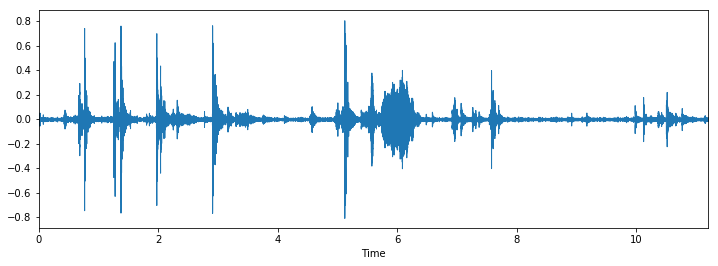

In [16]:
#Plot audio file cats_1 : Amplitude vs. Time
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=16000)
plt.show()

In [17]:
#Computing of the Mel-scaled spectrograms for each audio file
cats_mel_frequencies, dogs_mel_frequencies = compute_mel_frequencies(cats,dogs)

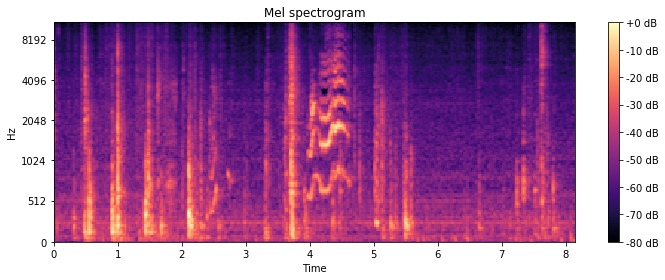

In [18]:
#Mel-scaled spectrogram of audio file cats_1 in decibel 
S = cats_mel_frequencies[0]
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=None,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [19]:
#Computing of the Mel-frequency cepstral coefficients for each audio file
cats_mfccs, dogs_mfccs = compute_mfccs(cats_mel_frequencies,dogs_mel_frequencies)

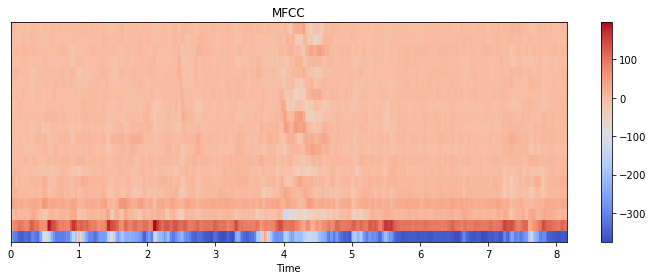

In [20]:
#Mel-frequency cepstral coefficients of audio file cats_1 
mfccs = cats_mfccs[0]
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [21]:
#Computing of the delta features for each audio file
cats_deltas, dogs_deltas = compute_deltas(cats_mfccs,dogs_mfccs)

In [22]:
#Removing silent frames for delta features and mfccs for each audio file
new_cats_mfccs,new_dogs_mfccs = remove_frames(cats,dogs,cats_mfccs, dogs_mfccs)
new_cats_deltas, new_dogs_deltas = remove_frames(cats,dogs,cats_deltas, dogs_deltas)

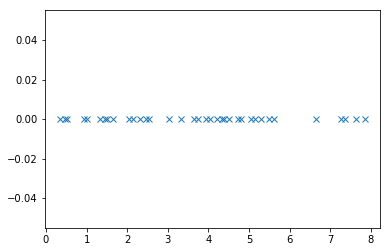

Non silent frame indexes: [ 15  20  22  40  44  57  63  65  71  88  92 100 106 109 130 143 157 161
 170 174 181 187 189 194 204 207 217 222 228 237 242 287 313 317 329 338]


In [23]:
#Plot onset detection results of audio file cats_1
detect = librosa.onset.onset_detect(y=x)
onset_times = librosa.frames_to_time(detect)
plt.plot(onset_times, np.zeros_like(onset_times) + 0, 'x')
plt.show()
print("Non silent frame indexes: " + str(detect))

In [24]:
#Merging mfccs and delta features
features_cats = [np.vstack((new_cats_mfccs[i],new_cats_deltas[i])) for i in range(len(cats_mfccs))]
features_dogs = [np.vstack((new_dogs_mfccs[i],new_dogs_deltas[i])) for i in range(len(dogs_mfccs))]

In [25]:
#Creating train and test dataframes with the desired features
df_train,df_test = split_data(new_cats_mfccs,new_dogs_mfccs,n_cats=n_cats,n_dogs=n_dogs,test_size=0.3)

In [26]:
#Classification with logistic regression using mfccs
y_train_last_lr,y_pred_train_last_lr,y_test_last_lr,y_pred_test_last_lr = log_reg(df_train,df_test)
train_acc_lr,test_acc_lr = calculate_accuracies(y_train=y_train_last_lr, y_pred_train = y_pred_train_last_lr, y_test = y_test_last_lr,y_pred_test = y_pred_test_last_lr)
class_report(y_train_last_lr,y_pred_train_last_lr,y_test_last_lr,y_pred_test_last_lr,train_acc_lr,test_acc_lr)



Training Set:

Training Confusion Matrix:
[[110   4]
 [ 14  65]]
Training Classification report:
             precision    recall  f1-score   support

          0       0.89      0.96      0.92       114
          1       0.94      0.82      0.88        79

avg / total       0.91      0.91      0.91       193

Train Accuracy: 0.906735751295


Test Set:

Test Confusion Matrix:
[[48  2]
 [12 22]]
Test Classification report:
             precision    recall  f1-score   support

          0       0.80      0.96      0.87        50
          1       0.92      0.65      0.76        34

avg / total       0.85      0.83      0.83        84

Test Accuracy: 0.833333333333


In [51]:
#Classification with support vector machine using mfccs
C,gamma = cross_validate(df_train,folds=3)
y_train_last_svm,y_pred_train_last_svm,y_test_last_svm,y_pred_test_last_svm = classification_svm(df_train,df_test,C,gamma)
train_acc_svm,test_acc_svm = calculate_accuracies(y_train=y_train_last_svm, y_pred_train = y_pred_train_last_svm, y_test = y_test_last_svm,y_pred_test = y_pred_test_last_svm)
class_report(y_train_last_svm,y_pred_train_last_svm,y_test_last_svm,y_pred_test_last_svm,train_acc_svm,test_acc_svm)



Training Set:

Training Confusion Matrix:
[[112   2]
 [  2  77]]
Training Classification report:
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       114
          1       0.97      0.97      0.97        79

avg / total       0.98      0.98      0.98       193

Train Accuracy: 0.979274611399


Test Set:

Test Confusion Matrix:
[[48  2]
 [10 24]]
Test Classification report:
             precision    recall  f1-score   support

          0       0.83      0.96      0.89        50
          1       0.92      0.71      0.80        34

avg / total       0.87      0.86      0.85        84

Test Accuracy: 0.857142857143


In [53]:
C,gamma

(1000000000.0, 9.9999999999999995e-08)